## Columns to be removed from training/validation

# Load Tensorflow and check GPU availability

In [2]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas import DataFrame
from pandas.core.dtypes import common as com

from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


2025-05-13 17:06:35.208886: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
/home/poli/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2025-05-13 17:06:35.208931: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: poli
2025-05-13 17:06:35.208936: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: poli
2025-05-13 17:06:35.209097: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostic

### Load subset from file

In [3]:
import pickle

# 3 skupiny grafů 

# 1. Samotné subsety - DONE 
    # phish
    # malware
    
# 2. Agregace (jen agregované subsety)
    # phish
    # malware
    
# 3. Staged (3-4 fáze)
    # phish

BACKUP_FILE = './experiment_data/phishing_aggregated.pickle'

def save_to_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}.")
    
    # save all the models 
    

def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Data loaded from {filename}.")
    return data

# Example usage:
# Assuming `results_grids` and `best_models` are the data you want to save.



In [4]:
loaded_data = load_from_pickle(BACKUP_FILE)
results_grids = loaded_data['results_grids']
top3_models = loaded_data['top3_models']
subset_dfs = loaded_data['subset_dfs']

[17:06:47] WARNING: ../src/gbm/gbtree.cc:415: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
[17:06:47] WARNING: ../src/gbm/gbtree.cc:425: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
[17:06:47] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
[17:06:48] WARNING: ../src/gbm/gbtree.cc:415: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
[17:06:48] WARNING: ../src/gbm/gbtree

### Visualize top models and overall results 

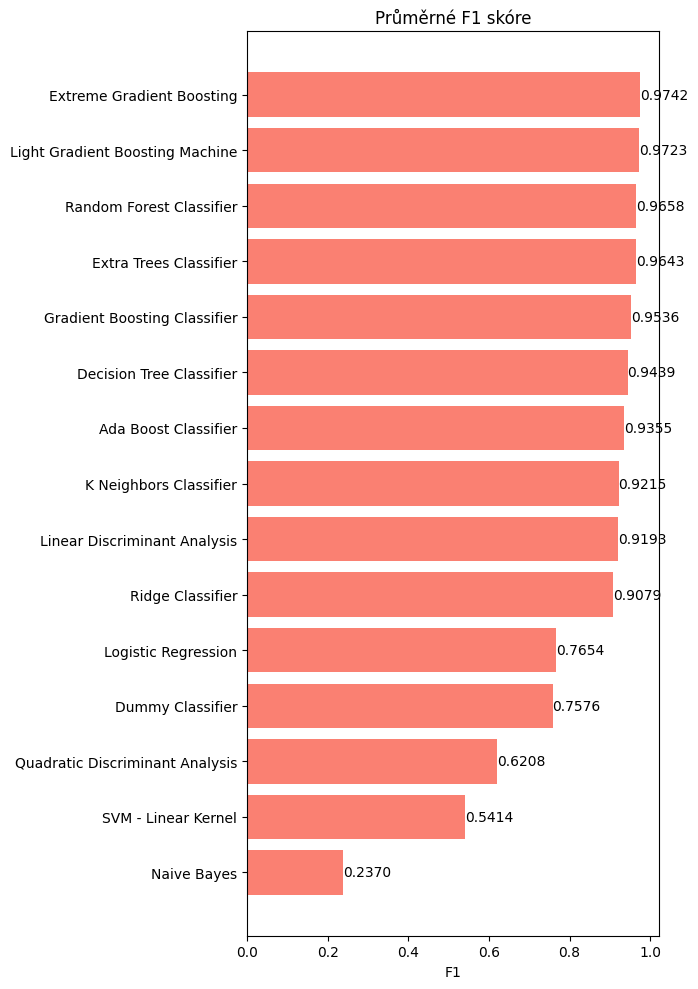

In [5]:
import matplotlib.pyplot as plt

# Extracting best F1 Scores and top models
best_f1_scores = []
model_names = []
subsets = []
top_models = {}

counter = 0
for prefix, grid in results_grids.items():
    # rename prefix to numbering
    prefix = f'{counter+1}'
    counter += 1
    # Best F1 score
    best_f1 = grid['F1'].max()
    best_f1_scores.append(best_f1)
    
    # Top 3 models
    top_3_models = grid.nlargest(3, 'F1')[['Model', 'F1']]
    top_models[prefix] = top_3_models
    model_names.append(top_3_models.iloc[0]['Model'])
    subsets = [s.replace('_html', '') for s in subsets]
    
    subsets.append(prefix)
    
# remove html from subsets


# Initialize figure
plt.figure(figsize=(18, 10))



# Plot 3: Ranking of Models Across All Feature Sets
model_rankings = pd.concat([grid[['Model', 'F1']] for grid in results_grids.values()])
mean_f1_by_model = model_rankings.groupby('Model')['F1'].mean().sort_values(ascending=True)
plt.subplot(1, 3, 3)
bars = plt.barh(mean_f1_by_model.index, mean_f1_by_model, color='salmon')
plt.title('Průměrné F1 skóre')
plt.xlabel('F1')
# Annotate exact average F1 scores
for bar, score in zip(bars, mean_f1_by_model):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center')
    
# save to pdf
plt.savefig('average_f1_models.pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()



In [5]:
!pip install tikzplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [6]:
# ┌────────────────────────────────────────────────────────────────────────────┐
# │  Compact F1‐heatmap with model & subset abbreviations + LaTeX lookup      │
# └────────────────────────────────────────────────────────────────────────────┘

print(results_grids.keys())

# 1) LaTeX/PGF backend + styling
import matplotlib as mpl
mpl.use("pgf")
mpl.rcParams.update({
    "pgf.texsystem":  "pdflatex",
    "font.family":    "serif",
    "text.usetex":    True,
    "pgf.rcfonts":    False,
    "font.size":      16,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize":15,
    "ytick.labelsize":15,
    "figure.figsize": (8, 6),
    "figure.dpi":     400,
    "axes.spines.top":   False,
    "axes.spines.right": False,
})

import pandas as pd, numpy as np, matplotlib.pyplot as plt

# 2) model full‐name → abbreviation
model_abbrev = {
    "Random Forest":  "RF",
    "Extreme Gradient Boosting":      "XGBoost",
    "Decision Tree":  "DT",
    "Ridge Classifier":"Ridge",
    "KNeighbors":    "KNN",
    "SVC":           "SVM",
    "LogisticRegression":"LR",
    "QuadraticDiscriminantAnalysis":"QDA",
    "Extra Trees Classifier":    "ET",
    "Light Gradient Boosting Machine":    "LGBM",
    "K Neighbors Classifier":    "KNN",
    "Gradient Boosting Classifier":    "GBM",
}

# 3) subset key → descriptive label
agg_abbrev = {
    'lex__agg':                               'Lex',
    'lex_+dns_+ip__agg':                      'Lex+dns+ip',
    'lex_+dns_+ip_+geo__agg':                 'Lex+...+geo',
    'lex_+dns_+ip_+tls_+geo__agg':            'Lex+...+tls',
    'lex_+dns_+ip_+tls_+geo_+rdap__agg':       'Lex+...+rdap',
    'lex_+dns_+ip_+tls_+geo_+rdap_+html__agg': 'Lex+...+html',
}

subset_abbrev = {
    # new basic ones
    'dns_':   'DNS',
    'tls_':   'TLS',
    'html_':  'HTML',
    'geo_':   'Geo',
    'rdap_':  'RDAP',
    'lex_':   'Lex',
    'ip_':    'IP',
}

subset_abbrev = agg_abbrev

order_labels = list(reversed(list(subset_abbrev.values())))


# 4) collect rows
rows = []
for key, grid in results_grids.items():
    label = subset_abbrev[key]
    top3 = grid.nlargest(3, "F1")[["Model","F1"]]
    for rank, (_, row) in enumerate(top3.iterrows(), start=1):
        raw = row["Model"]
        # pick abbreviation by substring match
        abbrev = next((ab for k,ab in model_abbrev.items() if k in raw), raw)
        rows.append({"Subset":label, "Rank":rank, "Model":abbrev, "F1":row["F1"]})

df = pd.DataFrame(rows)
pivot_f1    = df.pivot(index="Subset", columns="Rank", values="F1").reindex(order_labels)
pivot_model = df.pivot(index="Subset", columns="Rank", values="Model").reindex(order_labels)

# 5) plot heatmap
fig, ax = plt.subplots()
vmin,vmax = pivot_f1.values.min(), pivot_f1.values.max()
cax = ax.imshow(pivot_f1.values, aspect="auto", cmap="viridis", vmin=vmin, vmax=vmax)

for (i,j), val in np.ndenumerate(pivot_f1.values):
    txt = f"{pivot_model.iloc[i,j]}\n{val:.3f}"
    col = "white" if val < (vmin+vmax)/2 else "black"
    ax.text(j,i, txt, ha="center",va="center", fontsize=16, color=col)

ax.set_xticks([0,1,2]); ax.set_xticklabels(["1st","2nd","3rd"])
ax.set_yticks(range(len(order_labels))); ax.set_yticklabels(order_labels)
cb = fig.colorbar(cax, ax=ax, fraction=0.04, pad=0.04)
cb.set_label("F1", fontsize=16)
plt.tight_layout()

# 6) save
fig.savefig("fig_f1_abbrev.pdf", bbox_inches="tight")

lookup = [
    ("Lex",          "lex\\_agg",                                 63, 49037),
    ("Lex+dns+ip",   "lex\\_+dns\\_+ip\\_agg",                   111, 49037),
    ("Lex+...+geo",  "lex\\_+dns\\_+ip\\_+geo\\_agg",            129, 49037),
    ("Lex+...+tls",  "lex\\_+dns\\_+ip\\_+tls\\_+geo\\_agg",     153, 49037),
    ("Lex+...+rdap", "lex\\_+dns\\_+ip\\_+tls\\_+geo\\_+rdap\\_agg", 177, 49037),
    ("Lex+...+html", "lex\\_+dns\\_+ip\\_+tls\\_+geo\\_+rdap\\_+html\\_agg", 264, 49037),
]

table = [
r"\begin{table}[ht]",
r"  \centering",
r"  \caption{Feature‐subset label lookup}",
r"  \begin{tabular}{llrr}",
r"    \toprule",
r"    Label & Key & \# features & \# samples \\",
r"    \midrule",
]
for lab,key,nf,ns in lookup:
    table.append(f"    {lab} & \\texttt{{{key}}} & {nf} & {ns} \\\\")
table += [
r"    \bottomrule",
r"  \end{tabular}",
r"\end{table}"
]
print("\n".join(table))


dict_keys(['lex__agg', 'lex_+dns_+ip__agg', 'lex_+dns_+ip_+geo__agg', 'lex_+dns_+ip_+tls_+geo__agg', 'lex_+dns_+ip_+tls_+geo_+rdap__agg', 'lex_+dns_+ip_+tls_+geo_+rdap_+html__agg'])
\begin{table}[ht]
  \centering
  \caption{Feature‐subset label lookup}
  \begin{tabular}{llrr}
    \toprule
    Label & Key & \# features & \# samples \\
    \midrule
    Lex & \texttt{lex\_agg} & 63 & 49037 \\
    Lex+dns+ip & \texttt{lex\_+dns\_+ip\_agg} & 111 & 49037 \\
    Lex+...+geo & \texttt{lex\_+dns\_+ip\_+geo\_agg} & 129 & 49037 \\
    Lex+...+tls & \texttt{lex\_+dns\_+ip\_+tls\_+geo\_agg} & 153 & 49037 \\
    Lex+...+rdap & \texttt{lex\_+dns\_+ip\_+tls\_+geo\_+rdap\_agg} & 177 & 49037 \\
    Lex+...+html & \texttt{lex\_+dns\_+ip\_+tls\_+geo\_+rdap\_+html\_agg} & 264 & 49037 \\
    \bottomrule
  \end{tabular}
\end{table}
